# Замена пропусков с использованием предсказательной модели

## Imputing missing values using a predictive model




В этом блокноте сравним два способа замены пропусков:

- замена средним арифметическим;
- замена с использованием предсказательной модели, а именно линейной регрессии.

**Подключение библиотек и скриптов**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.4f}'.format
plt.rcParams['figure.figsize'] = (6, 4)
matplotlib.rcParams.update({'font.size': 14})

### Загрузка датасета

In [3]:
TRAIN_DATASET_PATH = '../project/train.csv'
TEST_DATASET_PATH = '../project/test.csv'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0000,47.9816,29.4428,6.0000,7,9.0000,1969,0.0890,B,B,33,7976,5,nan,0,11,B,"184,966.9307"
15053,41,3.0000,65.6836,40.0495,8.0000,7,9.0000,1978,0.0001,B,B,46,10309,1,240.0000,1,16,B,"300,009.4501"
4765,53,2.0000,44.9480,29.1976,0.0000,8,12.0000,1968,0.0496,B,B,34,7759,0,229.0000,1,3,B,"220,925.9085"
5809,58,2.0000,53.3530,52.7315,9.0000,8,17.0000,1977,0.4379,B,B,23,5735,3,"1,084.0000",0,5,B,"175,616.2272"
10783,99,1.0000,39.6492,23.7762,7.0000,11,12.0000,1976,0.0123,B,B,35,5776,1,"2,078.0000",2,4,B,"150,226.5316"


**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train.shape

(10000, 19)

### Приведение типов

Заменим категории числами в трех признаках.

In [6]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']
train[feature_bin_names] = train[feature_bin_names].replace({'A':0, 'B':1})

### Обработка пропусков

In [7]:
train.isna().sum()[train.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

Пропуски содержат две переменные. В этом блокноте будем заменять пропуски в `LifeSquare`.

**Базовый вариант** - обучим модель на данных без признаков с пропусками и проверим точность предсказания. Все последующие варианты замен будем сравнивать с полученным значением метрики.

In [8]:
feature_names = train.drop(['LifeSquare', 'Healthcare_1', 'DistrictId', 'Price'], axis=1).columns.to_list()
target_name = ['Price']

X = train[feature_names]
y = train[target_name]

Для предсказания используем `GradientBoostingRegressor`.

In [9]:
gb_model = GradientBoostingRegressor(random_state=42)

Точность предсказания оценим по метрике $R^2$ с использованием кросс-валидации.

In [10]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores_0 = cross_val_score(gb_model, X, y, scoring='r2', cv=cv)
print('R2: %.4f' % scores_0.mean())

R2: 0.7176


### Предобработка данных

Для предсказания с использованием линейной регрессии нам понадобится переменная, имеющая сильную линейную корреляцию с `LifeSquare`. Логично предположить, что это общая площадь - `Square`. Проверим коэффициент корреляции между этими признаками.

In [11]:
train.corr()['LifeSquare']['Square']

0.1961288217836941

Подозрительно маленькое значение. Проверим визуально взаимосвязь между этими признаками.

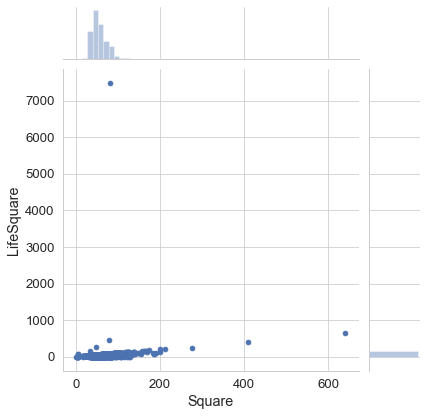

In [12]:
sns.jointplot(train['Square'], train['LifeSquare']);

Видим выбросы, которые портят зависимость. Выловим и удалим их.

In [13]:
train.loc[train['Square'] > 300]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
28,9,2.0000,604.7060,nan,1.0000,17,18.0000,1977,0.1615,1,1,25,5648,1,30.0000,2,4,1,"187,717.2425"
2307,102,1.0000,409.4252,410.6397,10.0000,4,4.0000,2016,0.2386,1,1,26,3889,6,705.0000,3,6,1,"90,470.4308"
11602,30,2.0000,641.0652,638.1632,10.0000,20,19.0000,2019,0.0001,1,1,22,6398,141,"1,046.0000",3,23,1,"133,529.6816"


Слишком низкая цена и небольшое количество комнат для таких больших площадей. 

In [14]:
train.loc[train['LifeSquare'] > 250]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14990,23,2.0000,48.4499,263.5420,5.0000,6,5.0000,1972,0.0758,1,1,6,1437,3,nan,0,2,1,"141,780.2319"
16550,27,3.0000,81.6944,"7,480.5921",1.0000,9,17.0000,2016,0.0176,1,1,2,469,0,nan,0,0,1,"217,357.4924"
2307,102,1.0000,409.4252,410.6397,10.0000,4,4.0000,2016,0.2386,1,1,26,3889,6,705.0000,3,6,1,"90,470.4308"
11602,30,2.0000,641.0652,638.1632,10.0000,20,19.0000,2019,0.0001,1,1,22,6398,141,"1,046.0000",3,23,1,"133,529.6816"
15886,85,3.0000,78.0593,461.4636,10.0000,12,16.0000,1998,0.0372,1,1,52,11217,1,"2,300.0000",1,7,1,"394,253.3000"


Либо цена низкая, либо жилая площадь сильно превышает общую.

Найдем индексы строк с аномальными квартирами и удалим их.

In [15]:
drop_index_list = train.loc[(train['Square'] > 300) | (train['LifeSquare'] > 250)].index
print(drop_index_list)
train.drop(index=drop_index_list, axis=0, inplace=True)
train.shape

Int64Index([14990, 28, 16550, 2307, 11602, 15886], dtype='int64', name='Id')


(9994, 19)

Удалили шесть строк из датасета $train$. Посмотрим, как это отразится на линейном коэффициенте корреляции и на графике.

In [16]:
train.corr()['LifeSquare']['Square']

0.7650482431544001

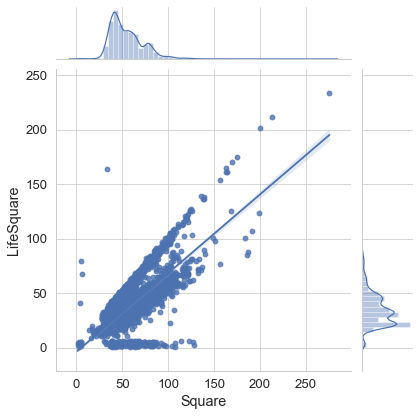

In [17]:
sns.jointplot(train['Square'], train['LifeSquare'], kind='reg');

Стало намного лучше. Можно еще почистить датасет, но вернемся к задаче - к замене пропусков.

**1 вариант** - заменим пропуски средней арифметической. Создадим новую переменную - `LifeSquare_mean`, копию `LifeSquare`. В ней произведем замену, чтобы не испортить исходный столбец.

Еще добавим столбец `LifeSquare_nan`, чтобы знать, где были пропуски в столбце `LifeSquare` (делать не обязательно, пригодится только для построения графика).


In [18]:
train['LifeSquare_mean'] = train['LifeSquare'] 
train['LifeSquare_mean'].fillna(train['LifeSquare'].mean(), inplace=True)

train['LifeSquare_nan'] = np.where(train['LifeSquare'].isna(), 1, 0)

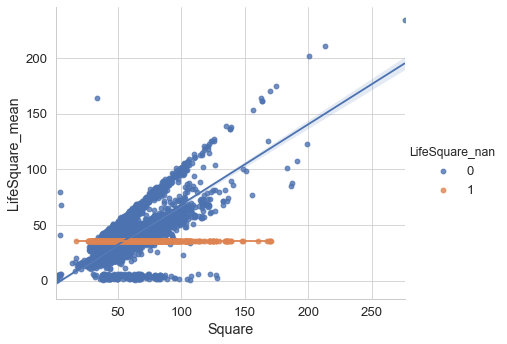

In [19]:
sns.lmplot(data=train, x='Square', y='LifeSquare_mean', hue='LifeSquare_nan', aspect=1.2);

Видим точки, полученные в ходе такой замены. Теперь добавим к массиву $X$ столбец `LifeSquare_mean` и снова обучим алгоритм и предскажем цену квартиры.

In [20]:
X = train[feature_names + ['LifeSquare_mean']]
y = train[target_name]

scores_1 = cross_val_score(gb_model, X, y, scoring='r2', cv=cv)
print('R2 without LifeSquare: \t\t%.4f' % scores_0.mean())
print('R2 with LifeSquare_mean: \t%.4f' % scores_1.mean())

R2 without LifeSquare: 		0.7176
R2 with LifeSquare_mean: 	0.7185


Метрика немного увеличилась. Даже такая грубая замена помогла предсказательной модели.

**2 вариант** - для замены пропусков построим модель линейной регрессии. Переменная `LifeSquare` будет представлена как функция от переменной `Square`. Пропуски в `LifeSquare` заменяются рассчитанными по этой функции значениями. 

Опять создадим копию `LifeSquare` - `LifeSquare_imp`. Нам нужно сформировать обучающий датасет и датасет с пропусками для предсказаний.

$\text{Square}$ будет содержать значения общей площади для квартир, у которых `LifeSquare` известна.

$\text{LifeSquare}$ - для этих же квартир известные жилые площади. 

$\text{Square_nan}$ - общие площади квартир, у которых стоят пропуски в столбце `LifeSquare`.

In [21]:
train['LifeSquare_imp'] = train['LifeSquare'] 
Square = train.loc[train['LifeSquare_imp'].notna(), ['Square']]
LifeSquare = train.loc[train['LifeSquare_imp'].notna(), 'LifeSquare_imp']
Square.shape, LifeSquare.shape

((7882, 1), (7882,))

In [22]:
Square_nan = train.loc[train['LifeSquare_imp'].isna(), ['Square']]
Square_nan.shape

(2112, 1)

Обучаем линейную регрессию и делаем предсказания жилой площади.

In [23]:
lr_model = LinearRegression()
lr_model.fit(X=Square, y=LifeSquare)
preds = lr_model.predict(Square_nan)

Записываем эти предсказания в переменную `LifeSquare_imp`.

In [24]:
train.loc[train['LifeSquare_imp'].isna(), ['LifeSquare_imp']] = preds

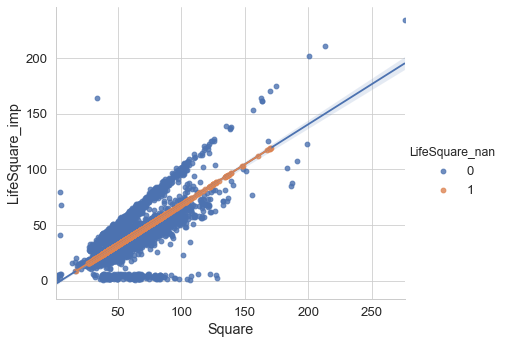

In [25]:
sns.lmplot(data=train, x='Square', y='LifeSquare_imp', hue='LifeSquare_nan', aspect=1.2);

На графике новые точки лежат прямо на регрессионной прямой.

Проверим, остались ли пропуски.

In [26]:
train['LifeSquare_imp'].isna().sum()

0

Обучим модель с добавлением нового признака `LifeSquare_imp`. Сравним метрики.

In [27]:
X = train[feature_names + ['LifeSquare_imp']]
y = train[target_name]

scores_2 = cross_val_score(gb_model, X, y, scoring='r2', cv=cv)
print('R2 without LifeSquare: \t\t%.4f' % scores_0.mean())
print('R2 with LifeSquare_mean: \t%.4f' % scores_1.mean())
print('R2 with LifeSquare_imp: \t%.4f' % scores_2.mean())

R2 without LifeSquare: 		0.7176
R2 with LifeSquare_mean: 	0.7185
R2 with LifeSquare_imp: 	0.7191


R2 хуже не стал :). Возможно, признак `LifeSquare` стоит оставить в модели после любой замены пропусков.

Проверим, как менялся коэффициент корреляции между признаками `LifeSquare` и `Square`.

In [28]:
train.corr()['LifeSquare']['Square'], \
train.corr()['LifeSquare_mean']['Square'], \
train.corr()['LifeSquare_imp']['Square']

(0.7650482431544001, 0.670819607005122, 0.804584964941861)

Также проверим, как менялся коэффициент корреляции между признаками `LifeSquare` и целевой переменной - `Price`.

In [29]:
train.corr()['LifeSquare']['Price'], \
train.corr()['LifeSquare_mean']['Price'], \
train.corr()['LifeSquare_imp']['Price']

(0.40055043022160347, 0.3636540537291066, 0.4116814253875971)

Осталось посмотреть значимость этих двух новых переменных для модели. 

In [30]:
X = train[feature_names + ['LifeSquare_mean', 'LifeSquare_imp']]
y = train[target_name]

gb_model.fit(X, y)
feature_importances = pd.DataFrame(gb_model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', 
                                                                       ascending=False)

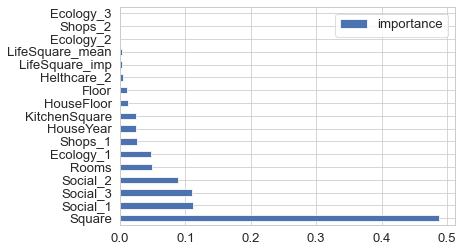

In [31]:
feature_importances.plot.barh();

Видим, что оба новых признака имеют низкую значимость для модели, в отличии от признака `Square`. Хотя `Square` и `LifeSquare` сильно коррелируют между собой. Возможно, дело в зашумленности данных в столбце `LifeSquare`. Так что вопрос об исключении признака `LifeSquare` пока остается открытым.

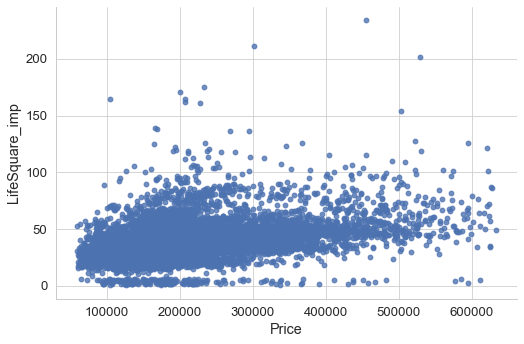

In [32]:
sns.lmplot(data=train, x='Price', y='LifeSquare_imp', fit_reg=False, aspect=1.5);

**Note:** В данном блокноте мы сравнили пару способов замены пропусков. Они НЕ являются универсальными и оптимальными. Это лишь демонстрация применения линейной регрессии для замены пропусков.